### GBM(Gradient Boosting Parameter Tunning)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline

In [2]:
## I downloaded both files and store at my Github profile.
df_nba = pd.read_csv("https://raw.githubusercontent.com/atulpatelDS/Data_Files/master/NBA_rookie/NBA_rookie.csv")

Dataset for practicing classification -use NBA rookie stats to predict if player will last 5 years in league

Classification Exercise: Predict 5-Year Career Longevity for NBA Rookies

y = 0 if career years played < 5

y = 1 if career years played >= 5

<img src="https://raw.githubusercontent.com/atulpatelDS/Machine_Learning/master/Images/NBA_Column_Description.png" width="340" height="240" align="left"/>

In [3]:
print(df_nba.shape)
print(type(df_nba))

(1340, 21)
<class 'pandas.core.frame.DataFrame'>


In [4]:
df_nba.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [5]:
## Check the intial data type, null value and unique counts
def initial_dataset_check(df):
    """
    A function to make initial check for the dataset including the name, data type, 
    number of null values and number of unique varialbes for each feature.
    """
    columns = df.columns    
    lst = []
    for feature in columns : 
        dtype = df[feature].dtypes
        num_null = df[feature].isnull().sum()
        num_unique = df[feature].nunique()
        lst.append([feature, dtype, num_null, num_unique])
    
    check_df = pd.DataFrame(lst)
    check_df.columns = ['feature','dtype','num_null','num_unique']
    check_df = check_df.sort_values(by='dtype', axis=0, ascending=True)
    
    return check_df

In [6]:
initial_dataset_check(df_nba)

,feature,dtype,num_null,num_unique
1,GP,int64,0,70
10,FTM,float64,0,59
18,BLK,float64,0,28
17,STL,float64,0,26
16,AST,float64,0,77
15,REB,float64,0,101
14,DREB,float64,0,74
13,OREB,float64,0,44
12,FT%,float64,0,383
11,FTA,float64,0,76


In [7]:
df_nba["3P%"].isnull().sum()

11

In [8]:
## Lets replace null value with mean
df_nba["3P%"] = df_nba["3P%"].fillna(value = df_nba["3P%"].mean())

In [9]:
df_nba["3P%"].isnull().sum()

0

In [10]:
X = df_nba.iloc[:,1:-1] ### Name need to remove which is distinct value
y = df_nba.TARGET_5Yrs

In [11]:
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(1340, 19)
(1340,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [12]:
## Now split the test train
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1072, 19)
(1072,)
(268, 19)
(268,)


In [14]:
X_cols = [x for x in X_train.columns]
X_cols

['GP',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG%',
 '3P Made',
 '3PA',
 '3P%',
 'FTM',
 'FTA',
 'FT%',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV']

**Define a function for modeling and Features Importance**
This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. plot Feature Importance

In [15]:
def modelfit(alg,X_train,y_train,X_test,y_test, X_cols, cv_folds=5):
    #Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    #y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    y_test_pred = alg.predict(X_test)
    #y_test_predprob = alg.predict_proba(X_test)[:,1]
    
    # Print the ROC_AUC on training dataset
    false_positive_rate_train, true_positive_rate_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred)
    roc_auc_score_train = metrics.roc_auc_score(y_train, y_train_pred)
    auc_train = metrics.auc(false_positive_rate_train, true_positive_rate_train)
    
    

    # Print the ROC_AUC on test dataset
    false_positive_rate_test, true_positive_rate_test, thresholds_test = metrics.roc_curve(y_test, y_test_pred)
    roc_auc_score_test = metrics.roc_auc_score(y_test, y_test_pred)
    auc_test = metrics.auc(false_positive_rate_test, true_positive_rate_test)
      
        
    #Print model report:
    print("\nBase Model Report with Default Parameters")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(y_train, y_train_pred))
    print("AUC (Train): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_train)
    print("Classification Report (Train): {}\n".format(metrics.classification_report(y_train,y_train_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_test, y_test_pred))
    print("AUC (Test): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_test)
    print("Classification Report (Test): {}\n".format(metrics.classification_report(y_test,y_test_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
            
    #Print Feature Importance:
    feat_imp = pd.Series(alg.feature_importances_, X_cols).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

We will AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC and ROC_AUC_SCORE is a good way for evaluation for this type of problems

#### Baseline GBM Model
with default parameters.


Base Model Report with Default Parameters
Accuracy (Train) : 0.861
AUC (Train): 0.836397
ROC_AUC_Score (Train): 0.836397
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.88      0.73      0.80       410
         1.0       0.85      0.94      0.89       662

    accuracy                           0.86      1072
   macro avg       0.87      0.84      0.85      1072
weighted avg       0.86      0.86      0.86      1072


Accuracy (Test) : 0.7201
AUC (Test): 0.836397
ROC_AUC_Score (Train): 0.675602
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.66      0.51      0.57        99
         1.0       0.74      0.85      0.79       169

    accuracy                           0.72       268
   macro avg       0.70      0.68      0.68       268
weighted avg       0.71      0.72      0.71       268




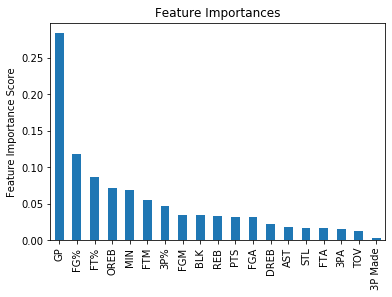

In [16]:
gbm = GradientBoostingClassifier(random_state=10)
gbm.fit(X_train,y_train)
modelfit(gbm,X_train,y_train,X_test,y_test, X_cols, cv_folds=5)

In [17]:
def modelfit_GS(alg,X_train,y_train,X_test,y_test, X_cols):
    #Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    #y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    y_test_pred = alg.predict(X_test)
    #y_test_predprob = alg.predict_proba(X_test)[:,1]
    
    # Print the ROC_AUC on training dataset
    false_positive_rate_train, true_positive_rate_train, thresholds_train = metrics.roc_curve(y_train, y_train_pred)
    roc_auc_score_train = metrics.roc_auc_score(y_train, y_train_pred)
    auc_train = metrics.auc(false_positive_rate_train, true_positive_rate_train)
    
    

    # Print the ROC_AUC on test dataset
    false_positive_rate_test, true_positive_rate_test, thresholds_test = metrics.roc_curve(y_test, y_test_pred)
    roc_auc_score_test = metrics.roc_auc_score(y_test, y_test_pred)
    auc_test = metrics.auc(false_positive_rate_test, true_positive_rate_test)
      
        
    #Print model report:
    print("\nBase Model Report with Default Parameters")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(y_train, y_train_pred))
    print("AUC (Train): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_train)
    print("Classification Report (Train): {}\n".format(metrics.classification_report(y_train,y_train_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_test, y_test_pred))
    print("AUC (Test): %f" % auc_train)
    print("ROC_AUC_Score (Train): %f" % roc_auc_score_test)
    print("Classification Report (Test): {}\n".format(metrics.classification_report(y_test,y_test_pred)))
    #print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_predprob))
    print("Best Score using GridSearch : {}\n".format(alg.best_score_))
    print("Best Parameter using GridSearch : {}\n".format(alg.best_params_))   
    
    ## Plot the Grapg with Mean test score 
    cv_results = pd.DataFrame(alg.cv_results_)
    plt.figure(figsize=(15,5))
    palette = sns.color_palette("Set1", n_colors=6, desat=.5)
    sns.lineplot(data=cv_results,x=cv_results.iloc[:,4],
                 y=cv_results.iloc[:,-3]
                 #,hue=cv_results["param_learning_rate"]
                 ,palette=palette
                 #,err_style="bars", ci=58,lw=1,err_kws={'capsize':0.5}
                 #,size=cv_results["param_learning_rate"]
                 #,sizes=(.25, 2.5)
                )
    

In [18]:
def plot_auc_gbm_parameter(param_value,param_name,X_train,y_train):
    train_results = []
    test_results = []
    for param in param_value:
        param_gs = {param_name:param_value}
        model = GridSearchCV(estimator=GradientBoostingClassifier(),param_grid=param_gs,n_jobs=8)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(param_value, train_results, color = 'green',label = "Train AUC") 
    line2, = plt.plot(param_value, test_results,color = 'red' ,label = "Test AUC") 
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("AUC score")
    plt.xlabel(param_name)
    plt.show()


Most data scientist see number of trees, tree depth and the learning rate as most crucial parameters.
There afre 2 types of parameters normally we tunned:

**Tree-specific parameters**

1. min_samples_split
2. min_samples_leaf
3. max_depth
4. min_leaf_nodes
5. max_features
6. loss function

**Boosting specific paramters**
1. n_estimators
2. learning_rate
3. subsample

**Find the Boosting Parameters**

1. n_estimators =  represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.
2. learning_rate = This determines the impact of each tree on the final outcome . GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.Lower values would require higher number of trees to model all the relations and will be computationally expensive.
3. subsample = The fraction of observations to be selected for each tree. Selection is done by random sampling. Values slightly less than 1 make the model robust by reducing the variance.Typical values ~0.8 generally work fine but can be fine-tuned further.

**Tree-specific parameters**
1. min_samples_split = represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples.
2. min_samples_leaf =  is The minimum number of samples required to be at a leaf node. This similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs.Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
3. max_depth = This indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data. We fit a decision tree with depths ranging from 1 to 32.
4. max_features = max_features represents the number of features to consider when looking for the best split.As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.


#### Tune the max_depth

In [19]:
predictors = X_cols
param_value1 = range(1,8)
param_name1 = "max_depth"
param_test1 =  {'max_depth':range(1,8)}
gs_gbm1 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10),param_grid = param_test1,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [20]:
%time gs_gbm1.fit(X_train,y_train)

Wall time: 4.49 s


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         


Base Model Report with Default Parameters
Accuracy (Train) : 0.7388
AUC (Train): 0.704495
ROC_AUC_Score (Train): 0.704495
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.70      0.56      0.62       410
         1.0       0.76      0.85      0.80       662

    accuracy                           0.74      1072
   macro avg       0.73      0.70      0.71      1072
weighted avg       0.73      0.74      0.73      1072


Accuracy (Test) : 0.7201
AUC (Test): 0.704495
ROC_AUC_Score (Train): 0.671418
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.67      0.48      0.56        99
         1.0       0.74      0.86      0.79       169

    accuracy                           0.72       268
   macro avg       0.70      0.67      0.68       268
weighted avg       0.71      0.72      0.71       268


Best Score using GridSearch : 0.7273629611723321

Best Parameter using GridSearch 

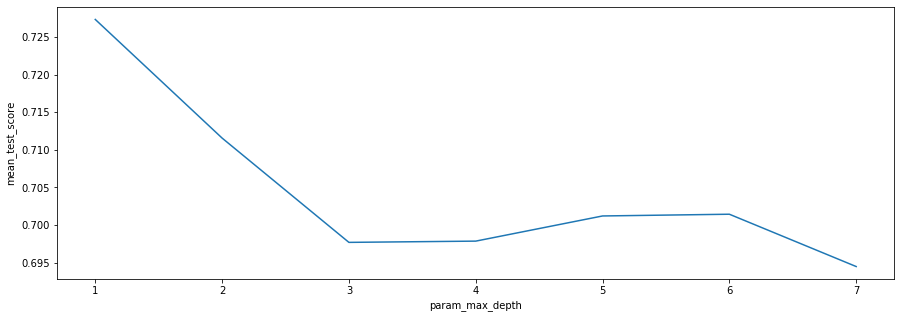

In [21]:
modelfit_GS(gs_gbm1,X_train,y_train,X_test,y_test, X_cols)

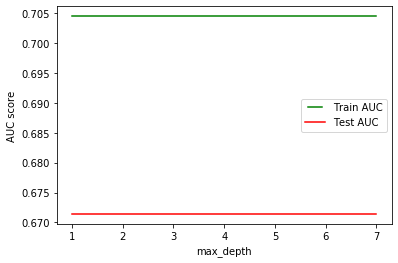

Wall time: 20.9 s


In [22]:
%time plot_auc_gbm_parameter(param_value1,param_name1,X_train,y_train)

#### Tune the learning rate

In [23]:
predictors = X_cols
param_value2 = [0.1,0.01,0.05,0.001]
param_name2 = "learning_rate"
param_test2 =  {"learning_rate":[0.1,0.01,0.05,0.001]}
gs_gbm2 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,max_depth = 1),param_grid = param_test2,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [24]:
%time gs_gbm2.fit(X_train,y_train)

Wall time: 638 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=1,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         


Base Model Report with Default Parameters
Accuracy (Train) : 0.7257
AUC (Train): 0.687422
ROC_AUC_Score (Train): 0.687422
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.68      0.52      0.59       410
         1.0       0.74      0.85      0.79       662

    accuracy                           0.73      1072
   macro avg       0.71      0.69      0.69      1072
weighted avg       0.72      0.73      0.72      1072


Accuracy (Test) : 0.7276
AUC (Test): 0.687422
ROC_AUC_Score (Train): 0.679427
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.68      0.49      0.57        99
         1.0       0.74      0.86      0.80       169

    accuracy                           0.73       268
   macro avg       0.71      0.68      0.69       268
weighted avg       0.72      0.73      0.72       268


Best Score using GridSearch : 0.7276641576224374

Best Parameter using GridSearch 

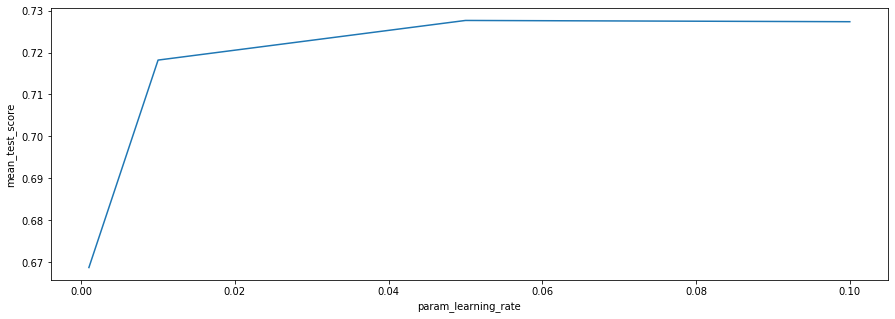

In [25]:
modelfit_GS(gs_gbm2,X_train,y_train,X_test,y_test, X_cols)

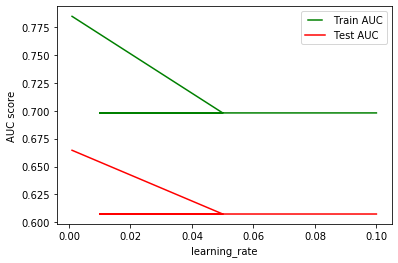

Wall time: 6.45 s


In [26]:
%time plot_auc_gbm_parameter(param_value2,param_name2,X_train,y_train)

In [27]:
predictors = X_cols
param_value3 = range(10,150,10)
param_name3 = "n_estimators"
param_test3 =  {"n_estimators":range(10,150,10)}
gs_gbm3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05,random_state=10,max_depth = 1),
                       param_grid = param_test3,
                       scoring='roc_auc',cv=5,n_jobs=8)

In [28]:
%time gs_gbm3.fit(X_train,y_train)

Wall time: 1.49 s


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='deviance', max_depth=1,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
        


Base Model Report with Default Parameters
Accuracy (Train) : 0.7164
AUC (Train): 0.674762
ROC_AUC_Score (Train): 0.674762
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.68      0.50      0.57       410
         1.0       0.73      0.85      0.79       662

    accuracy                           0.72      1072
   macro avg       0.70      0.67      0.68      1072
weighted avg       0.71      0.72      0.71      1072


Accuracy (Test) : 0.7276
AUC (Test): 0.674762
ROC_AUC_Score (Train): 0.679427
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.68      0.49      0.57        99
         1.0       0.74      0.86      0.80       169

    accuracy                           0.73       268
   macro avg       0.71      0.68      0.69       268
weighted avg       0.72      0.73      0.72       268


Best Score using GridSearch : 0.7292582203846645

Best Parameter using GridSearch 

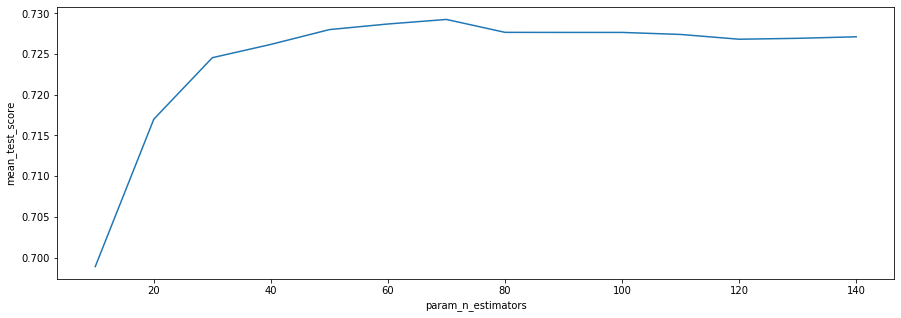

In [29]:
modelfit_GS(gs_gbm3,X_train,y_train,X_test,y_test, X_cols)

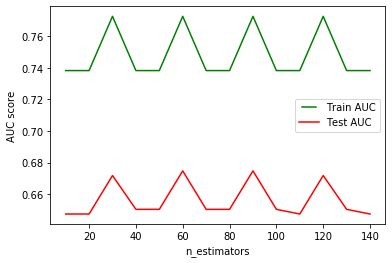

Wall time: 48 s


In [30]:
%time plot_auc_gbm_parameter(param_value3,param_name3,X_train,y_train)


Base Model Report with Default Parameters
Accuracy (Train) : 0.7164
AUC (Train): 0.674762
ROC_AUC_Score (Train): 0.674762
Classification Report (Train):               precision    recall  f1-score   support

         0.0       0.68      0.50      0.57       410
         1.0       0.73      0.85      0.79       662

    accuracy                           0.72      1072
   macro avg       0.70      0.67      0.68      1072
weighted avg       0.71      0.72      0.71      1072


Accuracy (Test) : 0.7276
AUC (Test): 0.674762
ROC_AUC_Score (Train): 0.679427
Classification Report (Test):               precision    recall  f1-score   support

         0.0       0.68      0.49      0.57        99
         1.0       0.74      0.86      0.80       169

    accuracy                           0.73       268
   macro avg       0.71      0.68      0.69       268
weighted avg       0.72      0.73      0.72       268




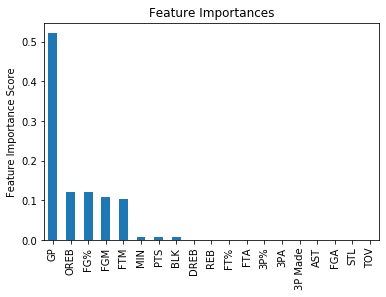

In [31]:
### Lets create the final model using best parameters
gbm_final = GradientBoostingClassifier(learning_rate=0.05,random_state=10,max_depth = 1,n_estimators=70)
gbm_final.fit(X_train,y_train)
modelfit(gbm_final,X_train,y_train,X_test,y_test, X_cols, cv_folds=5)